In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

### Load Raw Data

In [4]:
# df = pd.read_csv("data/raw_data.csv")   -   Sensitive data
print(df.shape)

(93822, 124)


### Initial Data Inspection

In [5]:
print(df.dtypes.unique()) # unique data types

print(df.isnull().values.any()) # check for missing values

print(df.duplicated().any()) # check duplicated rows

[dtype('int64') dtype('float64')]
False
False


In [6]:
# column names
list(df.columns)

['is_fraud',
 'username_count_of_letters',
 'username_count_of_vowels',
 'username_count_of_consonants',
 'username_count_of_capital_letters',
 'username_vowel_ratio',
 'username_consonant_ratio',
 'user_country_id1',
 'user_country_id2',
 'user_country_id3',
 'user_country_id4',
 'user_country_id5',
 'user_country_id6',
 'user_country_id7',
 'user_country_id8',
 'user_country_id9',
 'user_country_id10',
 'user_country_other',
 'user_country_high_risk',
 'user_country_medium_risk',
 'user_country_low_risk',
 'card_issuer_MASTERCARD',
 'card_issuer_VISA',
 'card_issuer_other',
 'card_type_CREDIT',
 'card_type_DEBIT',
 'card_users_number',
 'card_is_shared',
 'card_country_id1',
 'card_country_id2',
 'card_country_id3',
 'card_country_id4',
 'card_country_id5',
 'card_country_id6',
 'card_country_id7',
 'card_country_id8',
 'card_country_id9',
 'card_country_id10',
 'card_country_other',
 'card_country_high_risk',
 'card_country_medium_risk',
 'card_country_low_risk',
 'card_level_id1',


### Target Variable Distribution

In [7]:
df['is_fraud'].value_counts(normalize=True)

is_fraud
0    0.858455
1    0.141545
Name: proportion, dtype: float64

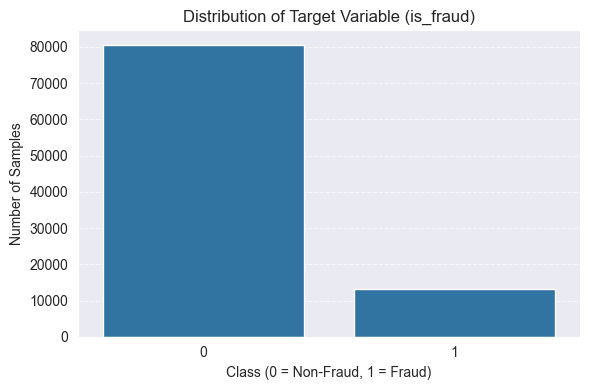

In [8]:
class_counts = df['is_fraud'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)

plt.title("Distribution of Target Variable (is_fraud)")
plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Number of Samples")
plt.xticks([0, 1])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
y = df['is_fraud']
X = df.drop('is_fraud', axis=1)

#### Visualizing 'is_fraud' with t-SNA

C:\Users\Markiyan Kruhliy\DataspellProjects\test_v1\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Markiyan Kruhliy\DataspellProjects\test_v1\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Markiyan Kruhliy\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Markiyan Kruhliy\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable,

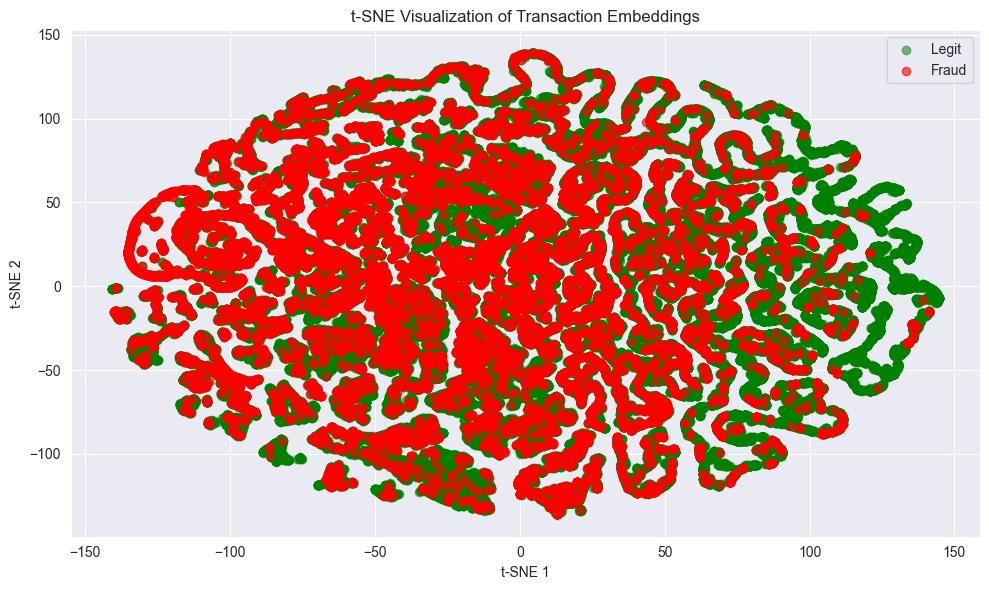

In [10]:
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[y == 0, 0], X_embedded[y == 0, 1], alpha=0.5, label='Legit', c='green')
plt.scatter(X_embedded[y == 1, 0], X_embedded[y == 1, 1], alpha=0.6, label='Fraud', c='red')
plt.title("t-SNE Visualization of Transaction Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Outliers Detection & Treatment

In [11]:
# separating binary vs non-binary columns
binary_cols = [col for col in df.columns if df[col].nunique() == 2]
non_binary_cols = [col for col in df.columns if df[col].nunique() > 2]

In [12]:
# identifying outliers in non-binary columns with Z-score
z_scores = np.abs(zscore(df[non_binary_cols]))

outlier_mask = z_scores > 3

outlier_counts = outlier_mask.sum(axis=0)
outlier_percentages = (outlier_counts / df[non_binary_cols].shape[0]) * 100

outlier_stats = pd.DataFrame({
    "Outlier Count": outlier_counts,
    "Outlier %": outlier_percentages
}, index=df[non_binary_cols].columns).sort_values(by="Outlier %", ascending=False)

outlier_stats

,Outlier Count,Outlier %
device_webrtc_count,4593,4.895440
email_domain_age,3055,3.256166
username_count_of_capital_letters,2906,3.097355
card_users_number,2562,2.730703
transaction_amount_eur,2425,2.584682
email_number_of_breaches,2352,2.506875
time_since_registration,2309,2.461043
username_vowel_ratio,1982,2.112511
username_consonant_ratio,1907,2.032572
ip_users_number,1382,1.473002


In [13]:
# clipping outliers (Winsorize)
for col in non_binary_cols:
    X[col] = winsorize(X[col], limits=[0.01, 0.01])

## Feature Selection

### Variance Threshold

In [14]:
X.var().sort_values(ascending=True).head(20)

email_domain_suspicious_tld    0.000575
ip_is_harmful                  0.000682
device_flash_enabled           0.001022
email_domain_registered        0.001256
device_webrtc_activated        0.001883
card_issuer_other              0.003272
email_disposable               0.004721
email_domain_spf_strict        0.005564
device_type_other              0.005680
ip_proxy                       0.006428
username_vowel_ratio           0.006986
username_consonant_ratio       0.007306
transaction_currency_other     0.007594
email_domain_website_exists    0.008245
font_hash_is_shared            0.009637
device_cookie_enabled          0.009793
phone_is_valid                 0.010774
transaction_currency_id2       0.011712
device_adblock                 0.012336
transaction_currency_id1       0.012658
dtype: float64

In [15]:
selector = VarianceThreshold(threshold=0.01)
X_var = pd.DataFrame(selector.fit_transform(X), columns=X.columns[selector.get_support()])

print("Dimensionality reduced from {} to {} features.".format(X.shape[1], X_var.shape[1]))

Dimensionality reduced from 123 to 107 features.


### Correlation Filter

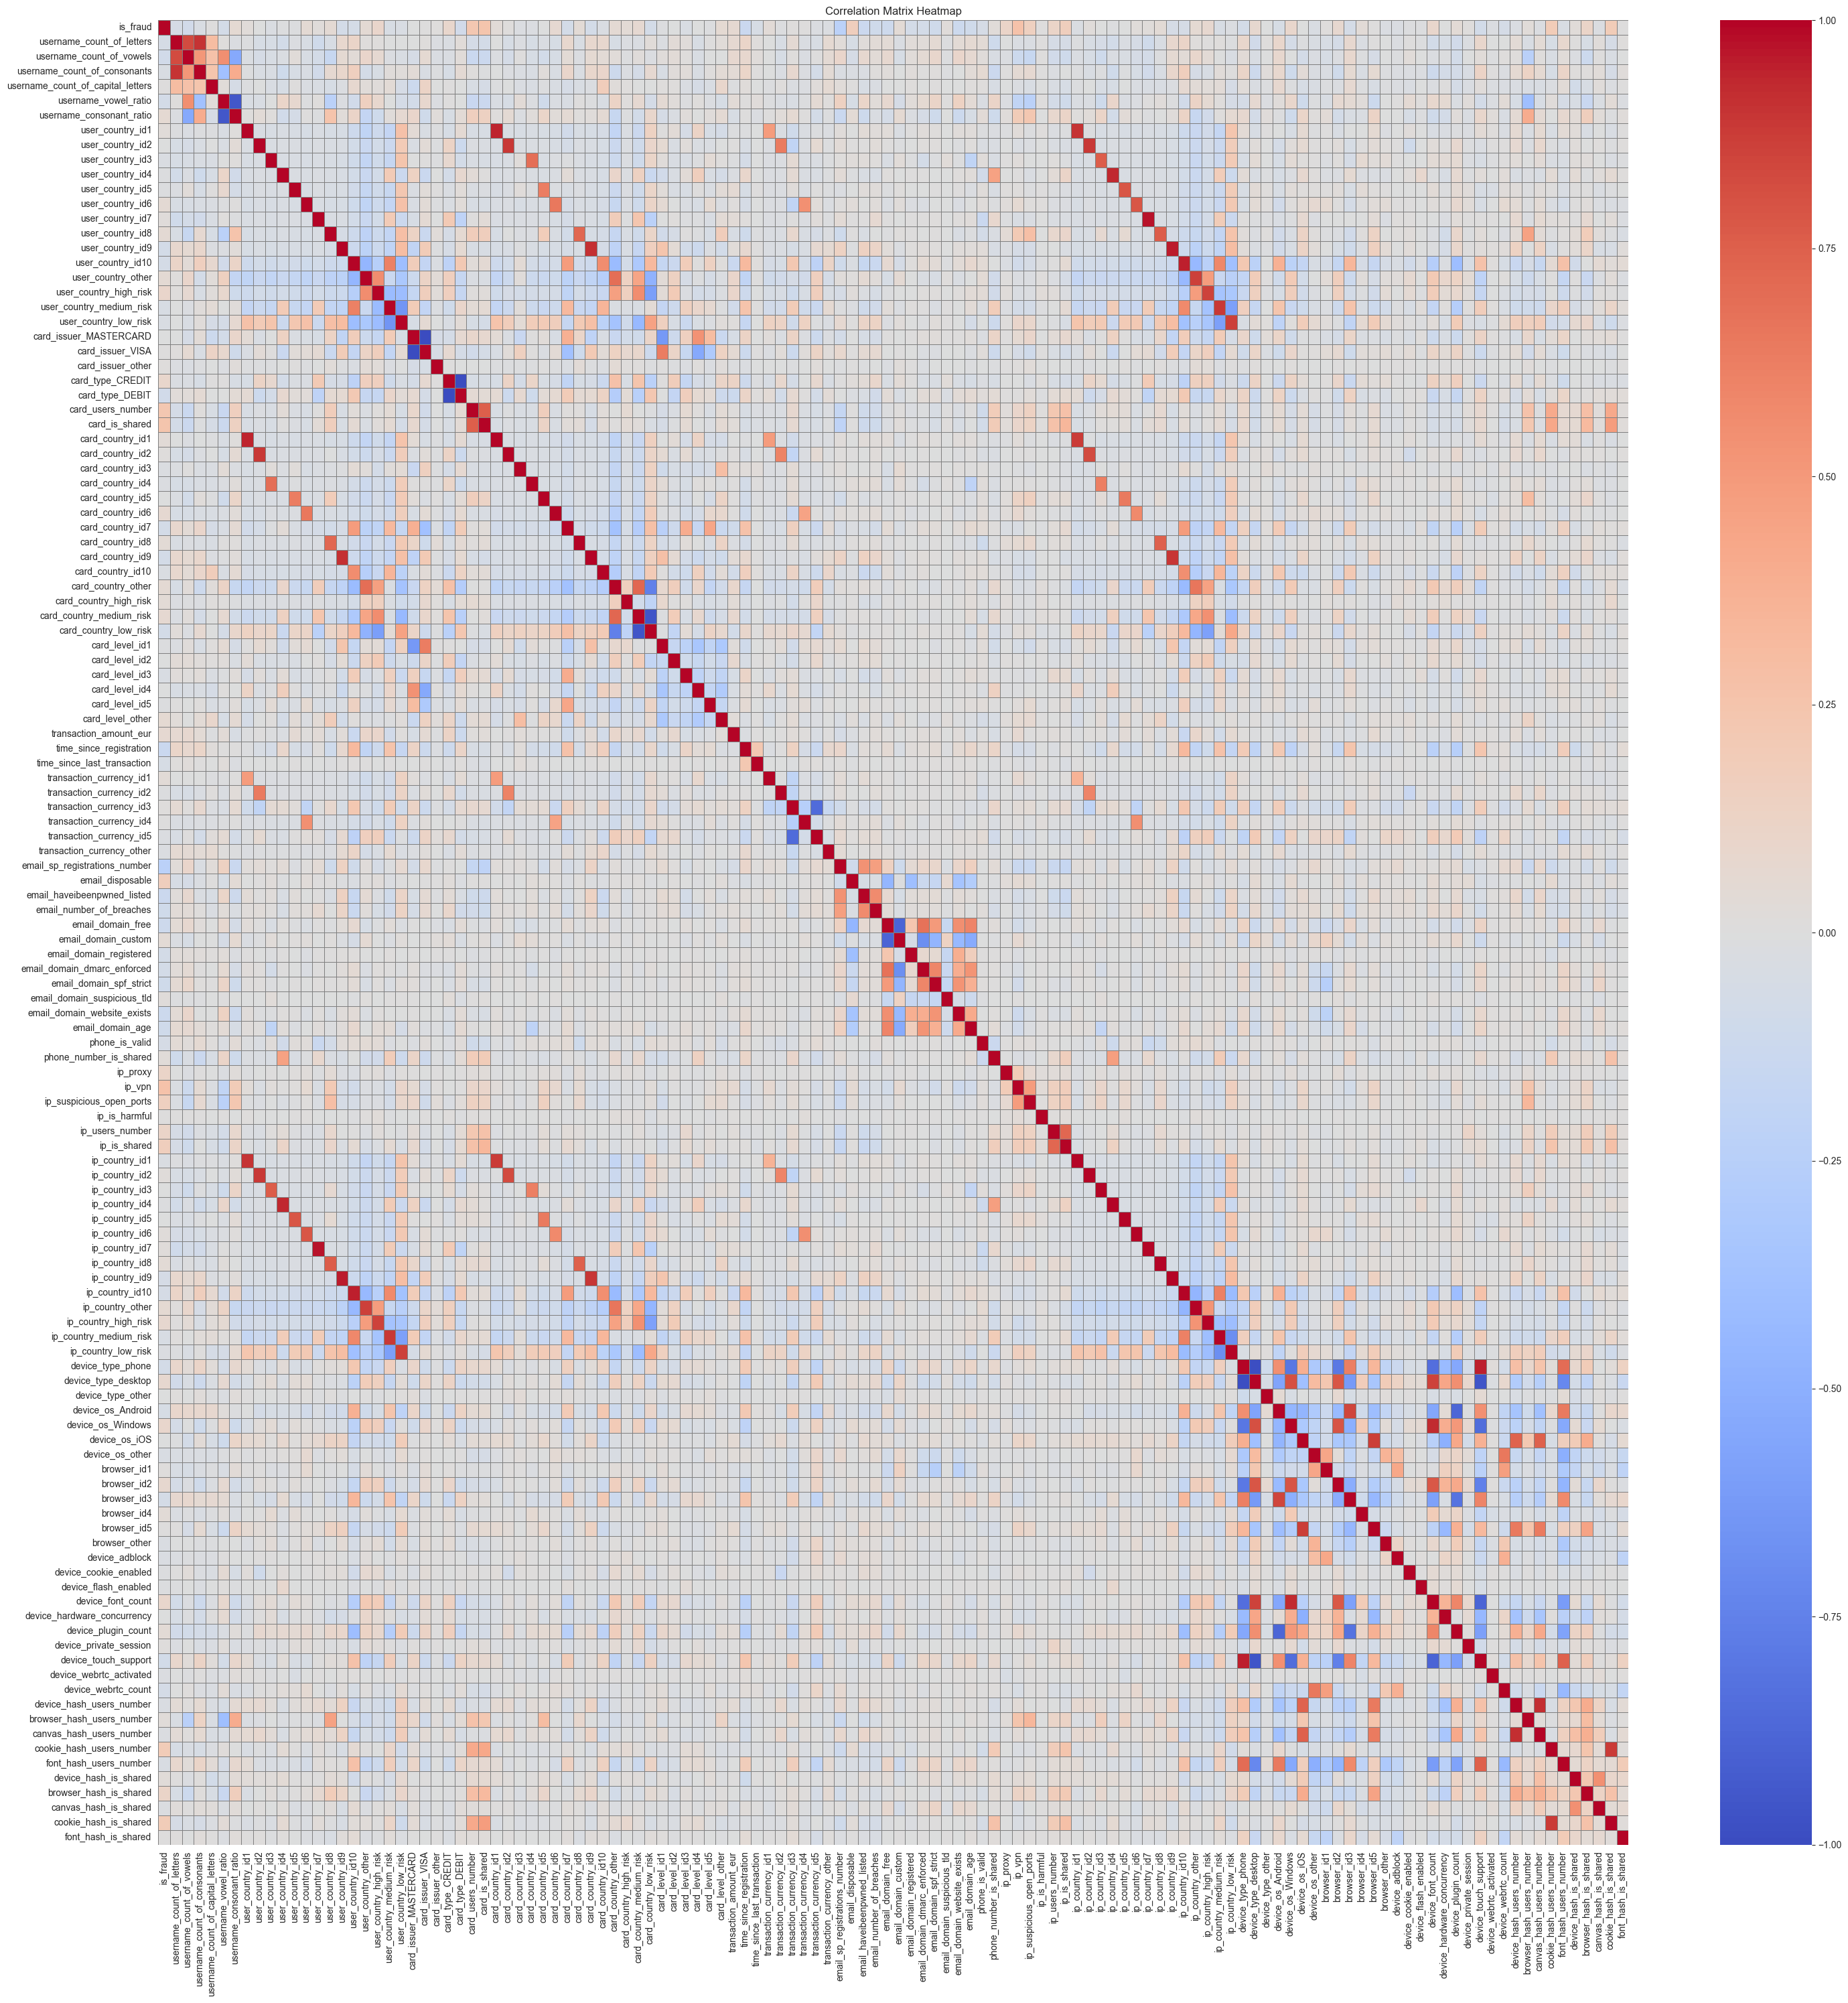

In [16]:
plt.figure(figsize=(30, 30))

sns.heatmap(df.corr(), cmap='coolwarm', annot=False, fmt=".2f",
            linewidths=0.5, linecolor='gray', cbar=True)

plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

In [17]:
corr_matrix = X_var.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_corr = X_var.drop(columns=to_drop)

print("Dimensionality reduced from {} to {} features.".format(X_var.shape[1], X_corr.shape[1]))

Dimensionality reduced from 107 to 100 features.


In [18]:
to_drop

['card_issuer_VISA',
 'card_type_DEBIT',
 'card_country_low_risk',
 'ip_country_id7',
 'ip_country_id9',
 'device_type_desktop',
 'device_touch_support']

### SelectKBest (mutual information)


In [19]:
skb = SelectKBest(score_func=mutual_info_classif, k=50)
X_mi = skb.fit_transform(X_corr, y)

selected_features = X_corr.columns[skb.get_support()]
X_mi = pd.DataFrame(X_mi, columns=selected_features)

print("Dimensionality reduced from {} to {} features.".format(X_corr.shape[1], X_mi.shape[1]))

Dimensionality reduced from 100 to 50 features.


In [20]:
# Dropped features
list(X_corr.columns[~skb.get_support()])

['user_country_id1',
 'user_country_id2',
 'user_country_id3',
 'user_country_id4',
 'user_country_id5',
 'user_country_id6',
 'user_country_id7',
 'user_country_id8',
 'user_country_id9',
 'user_country_id10',
 'card_country_id1',
 'card_country_id2',
 'card_country_id3',
 'card_country_id4',
 'card_country_id5',
 'card_country_id6',
 'card_country_id8',
 'card_country_id9',
 'card_country_id10',
 'card_country_high_risk',
 'card_level_id1',
 'card_level_id2',
 'card_level_id3',
 'card_level_id4',
 'card_level_id5',
 'transaction_currency_id1',
 'transaction_currency_id2',
 'transaction_currency_id4',
 'transaction_currency_id5',
 'email_domain_custom',
 'phone_number_is_shared',
 'ip_country_id1',
 'ip_country_id2',
 'ip_country_id3',
 'ip_country_id4',
 'ip_country_id5',
 'ip_country_id6',
 'ip_country_id8',
 'ip_country_id10',
 'ip_country_high_risk',
 'device_os_iOS',
 'device_os_other',
 'browser_id1',
 'browser_id2',
 'browser_id4',
 'browser_id5',
 'browser_other',
 'device_adb

### Selected Features

In [44]:
print(X_mi.columns)
print("\nNumber of selected features: {}".format(len(X_mi.columns)))

Index(['username_count_of_letters', 'username_count_of_vowels',
       'username_count_of_consonants', 'username_count_of_capital_letters',
       'user_country_other', 'user_country_high_risk',
       'user_country_medium_risk', 'user_country_low_risk',
       'card_issuer_MASTERCARD', 'card_type_CREDIT', 'card_users_number',
       'card_is_shared', 'card_country_id7', 'card_country_other',
       'card_country_medium_risk', 'card_level_other',
       'transaction_amount_eur', 'time_since_registration',
       'time_since_last_transaction', 'transaction_currency_id3',
       'email_sp_registrations_number', 'email_haveibeenpwned_listed',
       'email_number_of_breaches', 'email_domain_free',
       'email_domain_dmarc_enforced', 'email_domain_age', 'phone_is_valid',
       'ip_vpn', 'ip_suspicious_open_ports', 'ip_users_number', 'ip_is_shared',
       'ip_country_other', 'ip_country_medium_risk', 'ip_country_low_risk',
       'device_type_phone', 'device_os_Android', 'device_os_Wind

## Train/test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_mi,  # selected features from SelectKBest
    y,         # target variable
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"{X_test.shape[0]} rows in test set vs. {X_train.shape[0]} in training set. {X_test.shape[1]} Features.")

18765 rows in test set vs. 75057 in training set. 50 Features.


## Standardization

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Output scaled data as DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_mi.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_mi.columns)

In [23]:
pd.DataFrame(X_train_scaled).describe().T[['mean', 'std']]

,mean,std
0,-1.469706e-16,1.000007
1,1.945409e-16,1.000007
2,2.615178e-17,1.000007
3,-2.716945e-17,1.000007
4,-9.253708e-17,1.000007
5,2.716945e-17,1.000007
6,-3.938151e-17,1.000007
7,7.251499e-17,1.000007
8,9.921110e-17,1.000007
9,-1.175765e-16,1.000007


In [24]:
pd.DataFrame(X_test_scaled).describe().T[['mean', 'std']]

,mean,std
0,0.015191,1.008374
1,0.012625,0.993069
2,0.013631,1.007669
3,0.009838,1.022600
4,0.010154,1.000867
5,0.002374,1.001727
6,0.002743,1.000589
7,-0.004724,0.998977
8,0.005959,0.999755
9,0.003740,1.003228


## SMOTE

In [25]:
y_train.value_counts(normalize=True)

is_fraud
0    0.858454
1    0.141546
Name: proportion, dtype: float64

C:\Users\Markiyan Kruhliy\AppData\Local\Temp\ipykernel_11440\2790899796.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")


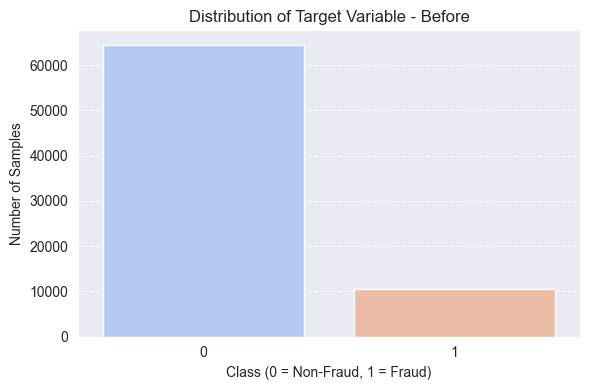

In [26]:
class_counts = y_train.value_counts().sort_index()

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")

plt.title("Distribution of Target Variable - Before")
plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Number of Samples")
plt.xticks([0, 1])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [27]:
# applying SMOTE to the scaled training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled_df, y_train)

In [28]:
print(f"Number of rows in train set increased from {X_train_scaled_df.shape[0]} to {X_train_resampled.shape[0]}")

Number of rows in train set increased from 75057 to 128866


In [29]:
y_train_resampled.value_counts(normalize=True)

is_fraud
0    0.5
1    0.5
Name: proportion, dtype: float64

C:\Users\Markiyan Kruhliy\AppData\Local\Temp\ipykernel_11440\676599455.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")


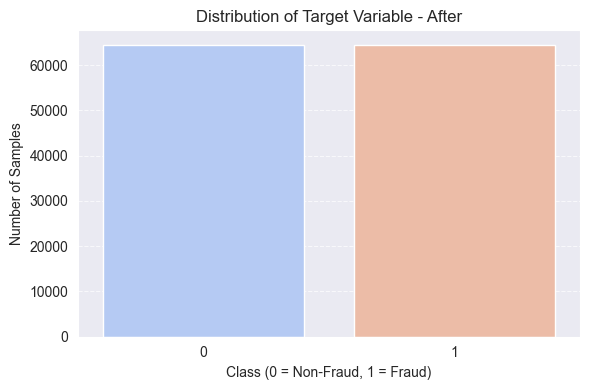

In [30]:
class_counts = y_train_resampled.value_counts().sort_index()

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")

plt.title("Distribution of Target Variable - After")
plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Number of Samples")
plt.xticks([0, 1])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

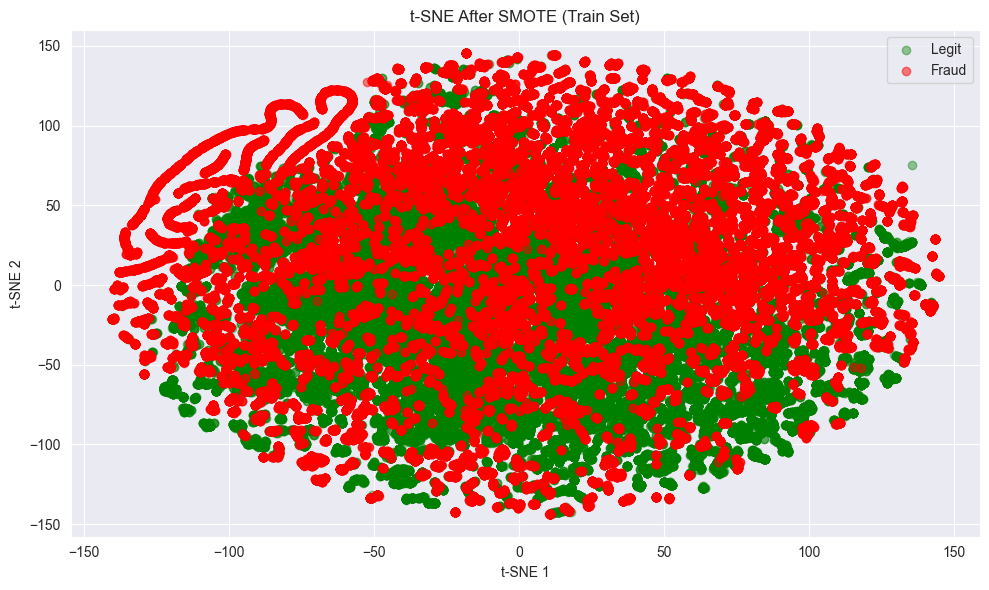

In [31]:
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_train_resampled)

plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[y_train_resampled == 0, 0], X_embedded[y_train_resampled == 0, 1], alpha=0.4, label='Legit', c='green')
plt.scatter(X_embedded[y_train_resampled == 1, 0], X_embedded[y_train_resampled == 1, 1], alpha=0.5, label='Fraud', c='red')
plt.title("t-SNE After SMOTE (Train Set)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## PCA

In [32]:
pd.DataFrame(X_train_resampled[:].values).describe().T[['mean', 'std']]

,mean,std
0,-0.063453,0.954642
1,-0.092638,0.999050
2,-0.034675,0.964641
3,-0.000903,1.016452
4,0.048007,0.998332
5,0.096498,1.059273
6,-0.047885,0.985318
7,-0.032246,0.989339
8,-0.000167,0.982221
9,0.080813,1.049065


In [33]:
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test_scaled_df)

print(f"PCA reduced the dataset to {X_train_pca.shape[1]} components to preserve 95% variance.")

PCA reduced the dataset to 33 components to preserve 95% variance.


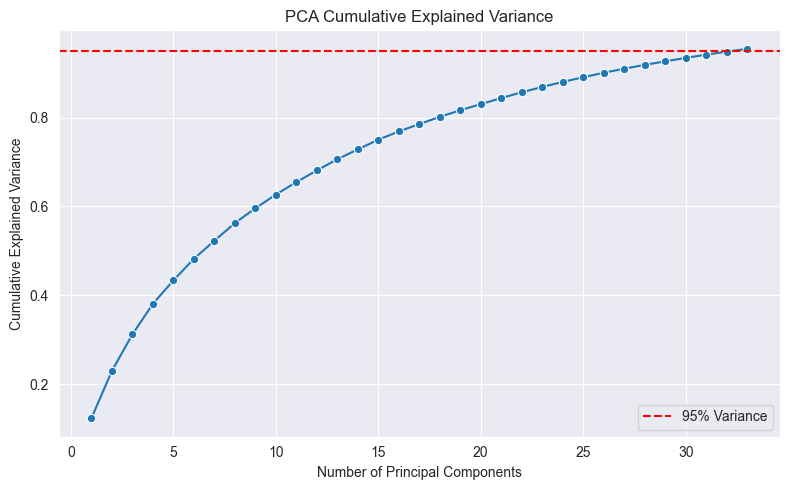

In [35]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, len(cumulative_variance) + 1), y=cumulative_variance, marker="o")
plt.axhline(0.95, color="r", linestyle="--", label="95% Variance")
plt.title("PCA Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X_train_resampled.columns,
)

In [37]:
top_features = loadings.abs().sort_values(by='PC1', ascending=False).head()
top_features

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33
cookie_hash_users_number,0.324425,0.293864,0.136782,0.012330,0.141979,0.239555,0.202031,0.092203,0.132762,0.009101,...,0.029053,0.006876,0.030239,0.142783,0.011670,0.002432,0.032786,0.041788,0.069614,0.012679
card_users_number,0.311399,0.251652,0.008431,0.037776,0.036940,0.041521,0.007196,0.051978,0.342324,0.149062,...,0.032418,0.024978,0.030625,0.083776,0.036107,0.040745,0.016792,0.063169,0.027354,0.050036
cookie_hash_is_shared,0.302165,0.285018,0.130925,0.020045,0.138136,0.225393,0.188361,0.086486,0.121836,0.021913,...,0.035474,0.040956,0.011949,0.063150,0.012097,0.000829,0.037234,0.021373,0.034651,0.015285
card_is_shared,0.291254,0.245046,0.000678,0.030317,0.025324,0.027242,0.003595,0.045578,0.278018,0.128546,...,0.012141,0.022553,0.005519,0.077892,0.042519,0.008064,0.019155,0.045816,0.017923,0.067767
device_type_phone,0.234722,0.227911,0.028458,0.007639,0.256950,0.061611,0.037916,0.081935,0.032407,0.018348,...,0.011647,0.015137,0.002632,0.004888,0.033035,0.002825,0.017901,0.028086,0.012514,0.007020


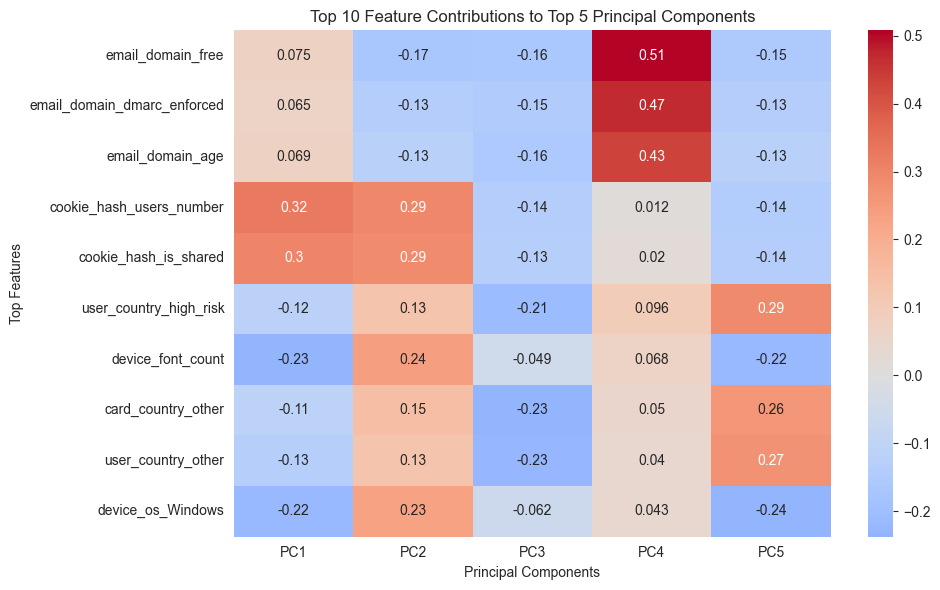

In [38]:
# top 5 PCs and top 10 features based on average absolute loading
top_pcs = loadings.columns[:5]
avg_abs_loading = loadings[top_pcs].abs().mean(axis=1)
top_features = avg_abs_loading.sort_values(ascending=False).head(10).index

heatmap_data = loadings.loc[top_features, top_pcs]

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0)
plt.title("Top 10 Feature Contributions to Top 5 Principal Components")
plt.xlabel("Principal Components")
plt.ylabel("Top Features")
plt.tight_layout()
plt.show()

## Saving Data

In [39]:
df_train = pd.DataFrame(X_train_pca)
df_train['is_fraud'] = y_train_resampled.values
print(df_train.shape)

(128866, 34)


In [40]:
df_test = pd.DataFrame(X_test_pca)
df_test['is_fraud'] = y_test.values
print(df_test.shape)

(18765, 34)


In [41]:
df_train.to_csv("data/train.csv", index=False)
df_test.to_csv("data/test.csv", index=False)